In [204]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson, uniform
from tqdm import tqdm

In [3]:
constraints = [
    (10, 8),  # no more than 10 wdraws in  8 epochs
    (20, 10), # no more than 20 wdraws in 10 epochs
]

In [11]:
T_MAX = max(constraints, key=lambda x:x[1])[1]
T_MAX

10

In [57]:
uniform.rvs(0, 1, size=10), poisson.rvs(mu=10)

(array([0.36641832, 0.7468677 , 0.23832683, 0.41801524, 0.67367168,
        0.40204133, 0.46168873, 0.86964308, 0.89587681, 0.58678066]),
 20)

In [232]:
history = []
pending = []
results = []
for t in tqdm(range(100000)):
    # Expire oldest withdrawals
    history = [h for h in history if (t - h[1]) > T_MAX]
    
    # Calc minslack
    slacks = []
    for c in constraints:
        delta_i, t_i = c
        relevant_history = [h for h in history if h[1] <= t_i]
        slack_i = delta_i - len(relevant_history)
        slacks.append(slack_i)
    minSlack = min(slacks)
    
    # Process withdrawals
    withdrawals = pending[:minSlack]
    newResults = [(w[0], t-w[1]) for w in withdrawals] # calc how long the withdrawal was in the queue
    results.extend(newResults)
    history.extend(withdrawals)
    pending = pending[minSlack:]
    
    
    # Add new pendings
    numWdraws = poisson.rvs(mu=8)
    newValues = uniform.rvs(0, 1, size=numWdraws)
    newPending = [(vi, t) for vi in newValues]
    pending.extend(newPending)

results = np.asarray(results)

100%|██████████| 100000/100000 [00:12<00:00, 8264.25it/s]


In [237]:
df = pd.DataFrame({"vs" : results[:,0], "times": results[:,1]})
bins = np.arange(0, 1.01, 0.01)
df["buckets"] = pd.cut(df.vs, bins)
df["avgs"] = df.groupby('buckets')['times'].transform('mean')
reduced = df[['buckets', 'avgs']].drop_duplicates()
reduced.head()

,buckets,avgs
0,"(0.46, 0.47]",1.109219
1,"(0.39, 0.4]",1.107427
2,"(0.18, 0.19]",1.103151
3,"(0.92, 0.93]",1.100198
6,"(0.73, 0.74]",1.105987


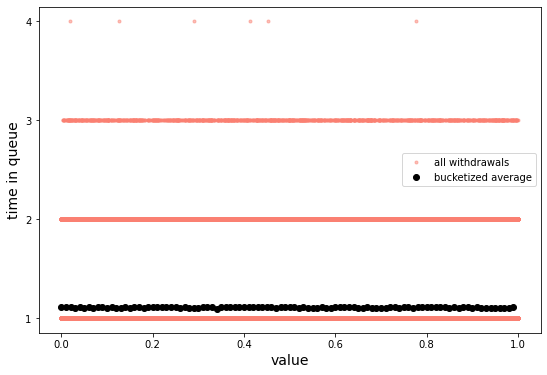

In [236]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(results[:,0], results[:,1], 
        linestyle="none", marker='.', color='salmon', alpha=0.5, label='all withdrawals')
ax.plot([b.left for b in reduced['buckets'].values], reduced['avgs'],
        linestyle="none", marker='o', color='black', alpha=1, label='bucketized average')

ax.set_yticks([1,2,3,4])
ax.set_xlabel('value', size=14)
ax.set_ylabel('time in queue', size=14)
ax.legend()
plt.show()

No handles with labels found to put in legend.


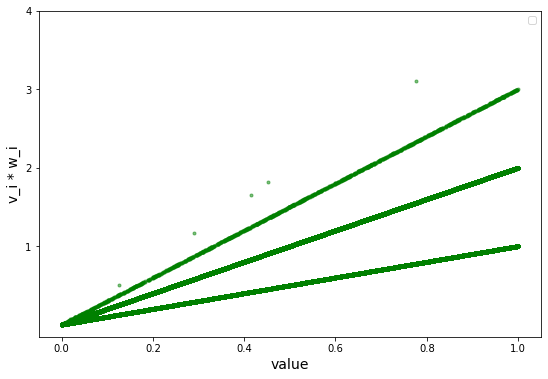

In [243]:
f, ax = plt.subplots(figsize=(9,6))

ax.plot(results[:,0], results[:,0] * results[:,1], 
        linestyle="none", marker='.', color='green', alpha=0.5)

ax.set_yticks([1,2,3,4])
ax.set_xlabel('value', size=14)
ax.set_ylabel('v_i * w_i', size=14)
plt.show()

In [242]:
np.mean(results[:,0] * results[:,1])

0.5530532909625596

In [160]:
df.buckets.values[:]

[(0.71, 0.72], (0.02, 0.03], (0.49, 0.5], (0.49, 0.5], (0.93, 0.94], ..., (0.47, 0.48], (0.67, 0.68], (0.12, 0.13], (0.64, 0.65], (0.36, 0.37]]
Length: 4937
Categories (100, interval[float64]): [(0.0, 0.01] < (0.01, 0.02] < (0.02, 0.03] < (0.03, 0.04] ... (0.96, 0.97] < (0.97, 0.98] < (0.98, 0.99] < (0.99, 1.0]]

In [165]:
df = pd.DataFrame({"vs" : results[:,0], "times": results[:,1]})
bins = np.arange(0, 1.01, 0.01)
df["buckets"] = pd.cut(df.vs, bins)
df["avgs"] = df.groupby('buckets')['times'].transform('mean')
reduced = df[['buckets', 'avgs']].drop_duplicates()
reduced.head()

,buckets,avgs
0,"(0.71, 0.72]",5.744681
1,"(0.02, 0.03]",5.350000
2,"(0.49, 0.5]",6.686275
4,"(0.93, 0.94]",5.608696
5,"(0.64, 0.65]",6.551724


<BarContainer object of 100 artists>

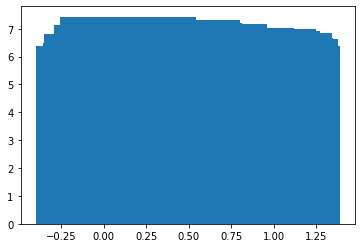

In [191]:
plt.bar([b.left for b in reduced['buckets'].values], reduced['avgs'])

In [150]:
df.groupby('buckets')['times'].transform('mean')

0       5.744681
1       5.350000
2       6.686275
3       6.686275
4       5.608696
          ...   
4932    6.345455
4933    6.637931
4934    5.824561
4935    6.551724
4936    6.300000
Name: times, Length: 4937, dtype: float64